# Visor NDVI

## Import libraries

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/observatorio/Documents/repos/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

# Imports que venían en el Notebook 15-min-city > 13-15-min-kepler-test.ipynb
import io
#import boto3
from keplergl import KeplerGl

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Config notebook

In [3]:
city_lst = ['Aguascalientes']
res = 8
projected_crs = 'EPSG:6372'
# Filter for urban areas only?
filter_urban = True
# Directory where .html files are saved
map_output_dir = str(project_root) + f"/data/processed/visor_ndvi/"

In [4]:
# Slope function
def calc_slope(row, cols):
    data = row[cols].astype(float).values
    slope, intercept = np.polyfit(years, data, 1)
    return slope

## Create Kepler HTMLs files by city

In [5]:
for city in city_lst:

    # 1.0 --- --- --- LOAD DATA --- --- ---
    
    # 1.1 --- LOAD URBAN HEXS
    print(f"Loading {city}'s urban hexs.")
    # Load data
    hex_schema = 'hexgrid'
    hex_table = f'hexgrid_{res}_city_2020'
    # Filter for urban areas if required
    if filter_urban:
        hex_type = 'urban'
        query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
    else:
        query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"
    # Read and format cols
    hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    hex_gdf['res'] = res
    hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_gdf.to_crs(projected_crs,inplace=True)
    # List all unique hex_ids
    hexid_lst = list(hex_gdf.hex_id.unique())
    
    # 1.2 --- LOAD NDVI DATA
    print(f"Loading {city}'s NDVI data.")
    ndvi_schema = 'raster_analysis'
    ndvi_table = 'ndvi_analysis_hex'
    query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
    ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    ndvi_gdf.to_crs(projected_crs,inplace=True)
    # Filter for urban areas if required
    if filter_urban:
        ndvi_gdf = ndvi_gdf.loc[ndvi_gdf.hex_id.isin(hexid_lst)].copy()
    # Inf values check
    infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
    if len(infs)>0:
        print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
        ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()

    
    # 2.0 --- --- --- CALCULATIONS --- --- ---
    
    # 2.1 --- CALCULATE NDVI SLOPE
    print(f"Calculating {city}'s NDVI slope.")
    years = np.array([2018, 2019, 2020, 2021, 2022, 2023])
    # --- --- --- Calculate slopes
    ndvi_columns = [f'ndvi_{year}' for year in years]
    ndvi_gdf['ndvi_slope'] = ndvi_gdf.apply(calc_slope, args=(ndvi_columns,), axis=1)

    # 2.2 --- CALCULATE NDVI CATEGORIES
    # Create vegetation categories
    ndvi_gdf['ndvi_median_rango'] = np.nan
    ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
    ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
                 (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
    ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
                 (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
    ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
                 (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
    ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

    # 3.0 --- --- --- DATA TREATMENT --- --- ---
    # Rename columns of interest
    main_col = 'Rango de vegetación'
    slope_col = 'Cambio 2018 a 2023'
    rename_columns = {'ndvi_median_rango':main_col,
                      'ndvi_slope':slope_col}
    hex_kepler = ndvi_gdf.copy()
    hex_kepler.rename(columns=rename_columns,inplace=True)
    # Keep columns of interest and geometry
    hex_kepler = hex_kepler[[main_col,slope_col,'geometry']]

# Show
print(hex_kepler.crs)
print(hex_kepler.shape)
hex_kepler.head(2)

Loading Aguascalientes's urban hexs.
Loading Aguascalientes's NDVI data.
Calculating Aguascalientes's NDVI slope.
EPSG:6372
(323, 3)


,Rango de vegetación,Cambio 2018 a 2023,geometry
3,Suelo,-0.034740,"POLYGON ((2464170.831 1107360.117, 2464643.87 ..."
5,Suelo artificial/Agua/Piedra,-0.016299,"POLYGON ((2465167.205 1107451.252, 2465640.232..."


<Axes: >

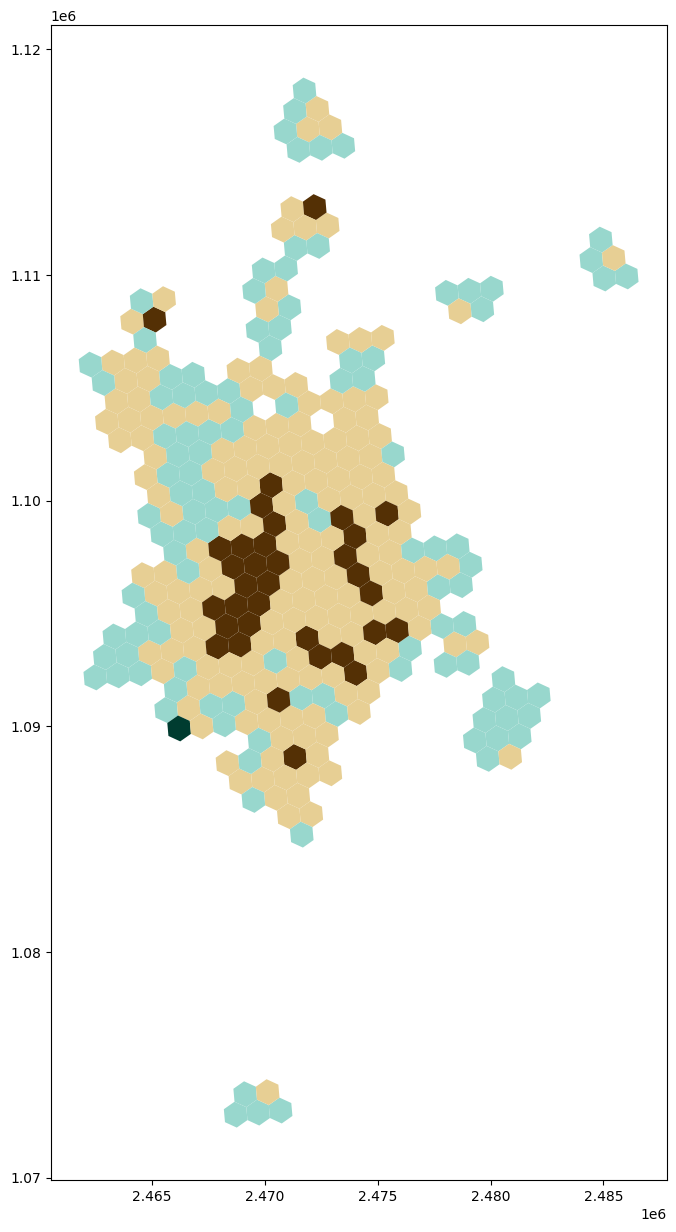

In [6]:
fig,ax = plt.subplots(figsize=(15,15))
hex_kepler.plot('Rango de vegetación',ax=ax,cmap='BrBG_r')

In [7]:
# 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
config,config_idx = aup.kepler_config()

config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"][
    "name"
] = main_col

config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
    "Análisis de hexágono"] = [main_col,slope_col]

#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [final_max_column, 'max_escuelas', 'pobtot']

# hex_gdf["d"] = 0
longitude = hex_kepler.dissolve().geometry.centroid.x
latitude = hex_kepler.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)
map_city = KeplerGl(height=800)
map_city.config = config
map_city.add_data(hex_kepler, name='Análisis de hexágono')
map_city

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jsx1yd', 'type': '…

In [8]:
map_city.save_to_html(file_name = map_output_dir+f"{city}_res{res}.html", read_only=False)

Map saved to /home/observatorio/Documents/repos/accesibilidad-urbana/data/processed/visor_ndvi/Aguascalientes_res8.html!
